Weak Lensing Null Test notebook.  

Chris W. and Keith B. for the SV bootcamp.  First version on 05/30/18.

In this notebook we use a the HSC 100 sq deg. Deep dataset to test:

- The agreement between the PSF model from PSFEX and the measured PSF from stars.
- Check shape correllation between stars and galaxies.

In [71]:
import glob
import numpy as np
import pandas as pd

from collections import OrderedDict

import lsst.daf.persistence as daf_persistence
import lsst.afw.display as afw_display
from lsst.afw.geom import Point2D

%matplotlib inline
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.dpi'] = 140
plt.rcParams['figure.dpi'] = 140

Define a function to RA and DEC center of a patch in a tract.

In [2]:
def getPatchCenter(skymap, tract, patch):
    '''
    Find the center of the patch BBox in pixel coordinates and convert with tract WCS
    An example of the format is:
    tract = 1800
    patch = '4,4'
    '''
    
    # Convert strings to ints
    patch = list(map(int, patch.split(','))) 

    # Get WCS for this tract
    wcs = skymap.generateTract(tract).getWcs()

    # Get four corners of patch
    bbox = skymap.generateTract(tract).getPatchInfo(patch).getInnerBBox() 

    # Manually calculate the center of the patch and then return the values converted to degrees
    sky = wcs.pixelToSky(np.mean((bbox.getBeginX(), bbox.getEndX())), 
                         np.mean((bbox.getBeginY(), bbox.getEndY())))
    return sky[0].asDegrees(), sky[1].asDegrees()

First open the HSC datafiles with the Butler

In [3]:
depth = 'DEEP'
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/{:s}/'.format(depth))

# In the generation 2 butler it isn't possibe to introspect the metadata for any step after the initial
# data ingest.  This code parses the names of the files to build a dataframe for later inspection.

infiles = glob.glob('/datasets/hsc/repo/rerun/DM-13666/{:s}/deepCoadd-results/HSC-I/*/*/calexp-*.fits'
                    .format(depth))

# Get the skymap for the repo so we can understand where the tracks and patches are
skymap = butler.get('deepCoadd_skyMap')


# Now get the names of the tracts and patches based on the file parsing
tract_array = []
patch_array = []
for i in range(0, len(infiles)):
    parts = infiles[i].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])

number_patches = len(patch_array)

# Create arrays to hold the RA and DEC of the centers of the patches
ra_center_array = np.empty(number_patches, dtype=np.float)
dec_center_array = np.empty(number_patches, dtype=np.float) 

# Loop through the patches and figure out where their centers are in degrees
for index, (tract, patch) in enumerate(zip(tract_array, patch_array)):
    ra_center_array[index], dec_center_array[index] = getPatchCenter(skymap, tract, patch)
    
print('Found {:d} patches'.format(number_patches))

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Found 1303 patches


In [4]:
# Make a pandas dataframe with information on each tract and patch
data = OrderedDict({'tract': tract_array,
        'patch': patch_array, 
        'ra_center': ra_center_array, 
        'dec_center': dec_center_array})

df_tract_patch = pd.DataFrame(data=data)

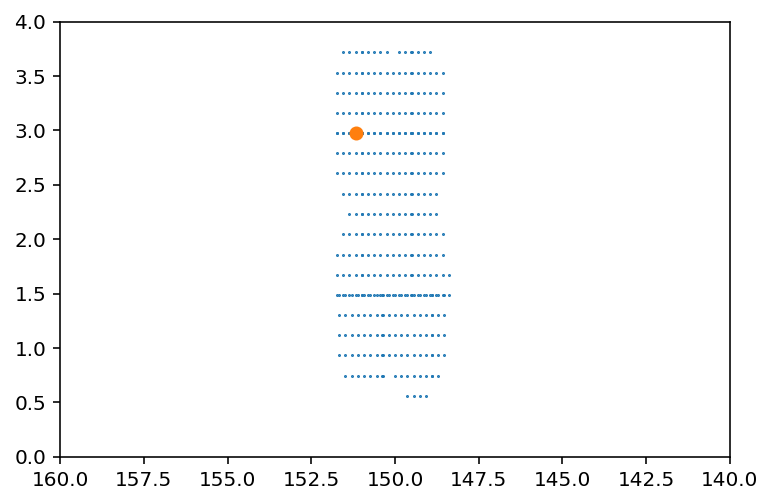

In [5]:
# Make sure the readout of the tract patch metadata file looks reasonable
plt.figure()
plt.scatter(df_tract_patch.ra_center, df_tract_patch.dec_center, marker='.', s=1)
# Centered on COSMOS field
plt.xlim(160., 140.)
plt.ylim(0., 4.)

# Pick one patch

#df_tract_patch.query('ra_center > 140 & ra_center < 160 & dec_center<4')
selected_patch = df_tract_patch.query("tract==10056 and patch == '7,0'")
plt.scatter(selected_patch.ra_center, selected_patch.dec_center)

In [6]:
selected_patch

,tract,patch,ra_center,dec_center
341,10056,"7,0",151.174802,2.972288


Use the Butler to grab the information on this patch and look at it.

In [7]:
# Create a dataid
filter_id = 'HSC-I'
tract_id = selected_patch.tract.values[0]
patch_id = selected_patch.patch.values[0]

# Use the butler to grab the information of this patch
data_id = {'filter':filter_id, 'tract':tract_id, 'patch':patch_id}
coadd_calexp = butler.get('deepCoadd_calexp', dataId=data_id)
coadd_calib = butler.get('deepCoadd_calexp_calib', dataId=data_id)
coadd_forced_src = butler.get('deepCoadd_forced_src', dataId=data_id)
coadd_ref = butler.get('deepCoadd_ref', dataId=data_id)

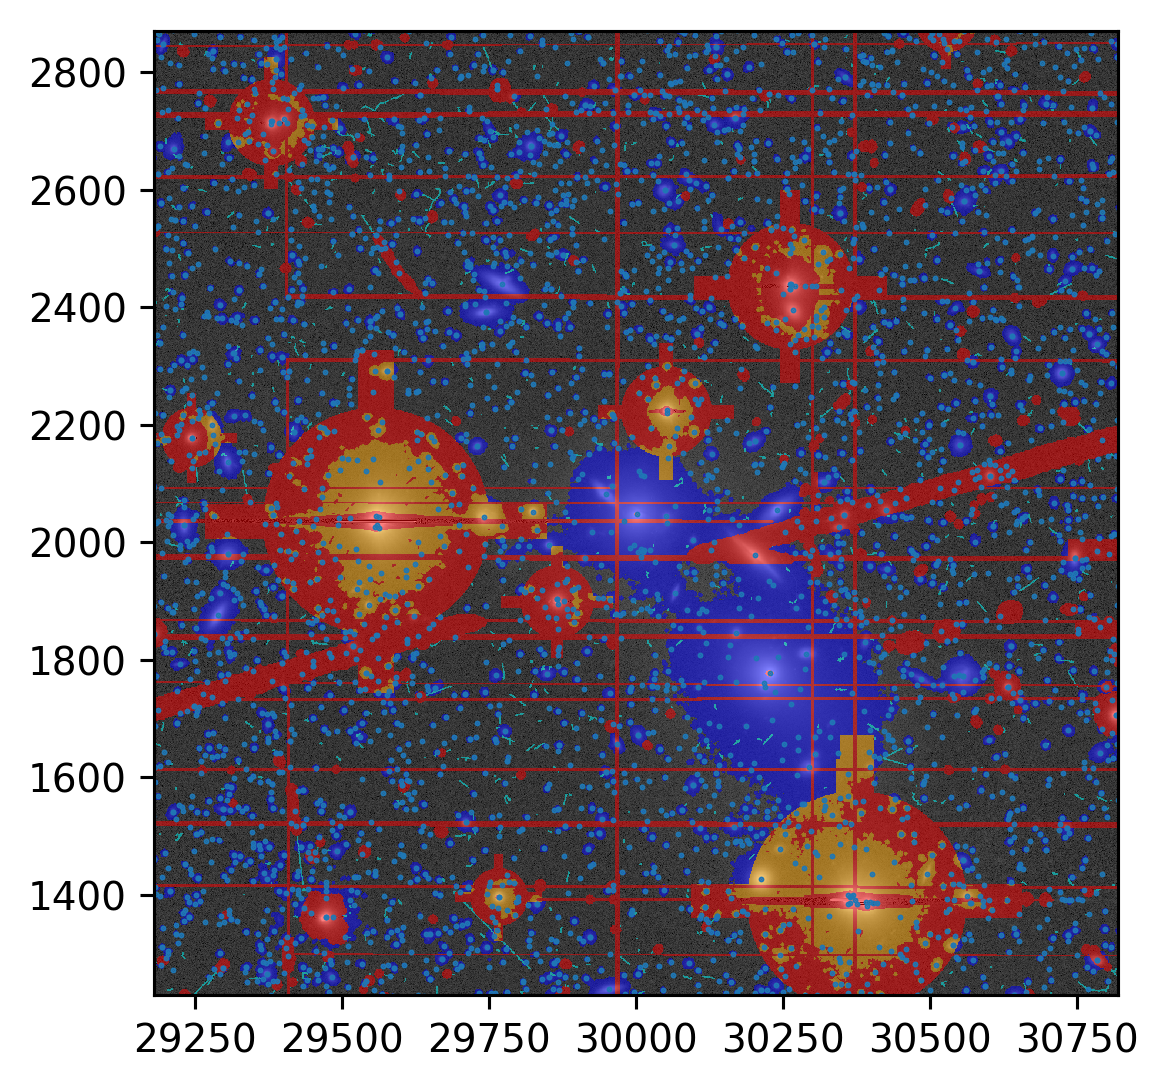

In [24]:
afw_display.setDefaultBackend('matplotlib')
calexp_display = afw_display.Display()

calexp_display.scale("asinh", "zscale")
calexp_display.setMaskTransparency(50)

calexp_display.mtv(coadd_calexp)
plt.scatter(coadd_forced_src.getX(), coadd_forced_src.getY(), marker='.', s=1)
calexp_display.zoom(5)

Now get the PSF Model Shape at each source

In [44]:
# Get forced photometry sources
sources_df = coadd_ref.asAstropy().to_pandas()

# Get the PSF model
psf_model = coadd_calexp.getPsf()

Make a new dataframe with cuts applied with only some columns

In [100]:
cut_primary = 'detect_isPrimary'

cut_pixel ='not (base_PixelFlags_flag_interpolatedCenter or \
    base_PixelFlags_flag_saturatedCenter)' 

cut_model = 'not (base_PsfFlux_flag or modelfit_CModel_flag)' 

cut_flux = 'base_PsfFlux_flux > 0 and modelfit_CModel_flux > 0'

cut_star = 'base_ClassificationExtendedness_value == 0'

cut_list = [cut_primary, cut_pixel, cut_model, cut_flux, cut_star]

cut = ' and '.join(cut_list) 

restricted_columns = ['coord_ra','coord_dec','slot_Centroid_x','slot_Centroid_y',
                      'slot_PsfFlux_flux',
                      'slot_PsfShape_xx', 'slot_PsfShape_yy', 'slot_PsfShape_xy',
                      'slot_Shape_xx', 'slot_Shape_yy', 'slot_Shape_xy']

selected_sources = sources_df.query(cut)[restricted_columns]

Add some additional calculated quantities

In [120]:
additional_columns = selected_sources \
                .assign(diff_xx = lambda x: x.slot_Shape_xx - x.slot_PsfShape_xx) \
                .assign(diff_yy = lambda x: x.slot_Shape_yy - x.slot_PsfShape_yy)
                

Plot a difference between the _XX element of the PSF model and the measured value.

(0.001, 1122.0184543019618)

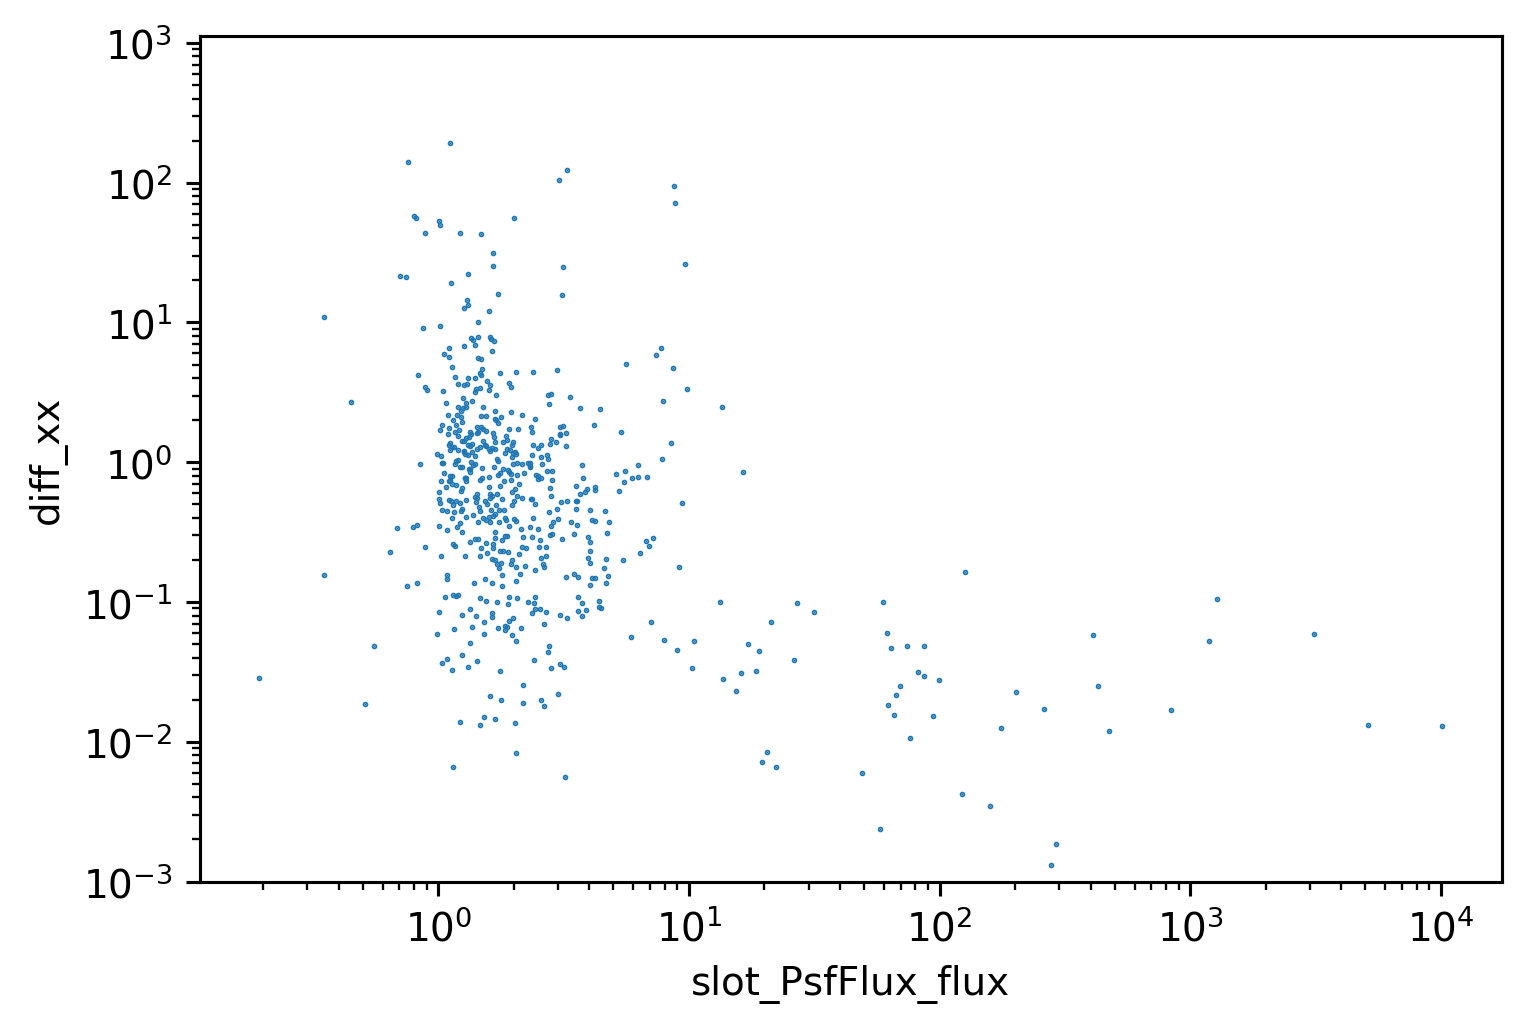

In [133]:
additional_columns.query('diff_xx>0').plot.scatter('slot_PsfFlux_flux', 'diff_xx', marker="o", s=.2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(.001)

**Next Step** Calculate ellipticity etc